In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import jetsimpy 
from astropy.cosmology import Planck15 as cosmo

def model(jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit,lf, A, s, t, nu):
    dl = cosmo.luminosity_distance(z).to("Mpc").value
    print(f"Luminosity distance: {dl} Mpc")
    P = dict(
        eps_e=10 ** logepse,
        eps_b=10 ** logepsb,
        p=p,
        theta_v=thv,
        d=dl,
        z=z,
    )
    
    jet_P = dict(
        Eiso=10 ** loge0,
        lf=lf,  # no coasting phase
        theta_c=thc,
        n0=10 ** logn0,
        A=A,  # no wind
        s=s,
    )

    # TODO: Ignoring jetType
    jet = jetsimpy.Jet(
        jetsimpy.PowerLaw(
            jet_P["theta_c"], jet_P["Eiso"], lf0=jet_P["lf"], s=jet_P["s"]
        ),
        nwind=jet_P["A"],
        nism=jet_P["n0"],
        grid=jetsimpy.ForwardJetRes(jet_P["theta_c"], 129),
        # allow spread or not
        spread=True,
        tmin=10.0,
        tmax=3.2e9,
        tail=True,
        cal_level=1,
        rtol=1e-6,
        cfl=0.9,
    )
    
    model_flux = jet.FluxDensity(
        t,  # [second]
        nu,  # [Hz]
        P,
        model="sync",  # radiation model
        rtol=1e-3,  # integration tolerance
        max_iter=100,
        force_return=True,
    )
    return model_flux

def lc_plot(
        jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit,lf=300, A=0, s=6):
    # Time and Frequencies
    ta = 1.0e-2 * 86400
    tb = 1.0e2 * 86400
    t = np.geomspace(ta, tb, num=100)

    df_allobs = pd.read_csv(observed_data)
    df_fit = pd.read_csv(observed_data_fit)

    frequencies = df_allobs[['Filt','Freqs']].drop_duplicates().sort_values(by='Freqs').to_numpy()

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'
    colors = cmap(np.linspace(0, 1, len(frequencies)))

    for i, (band,nu) in enumerate(frequencies):
        print(f"Calculating for frequency: {nu}")
        Fnu_model = []
        
        Fnu_model = model(jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit,lf, A, s, t, [nu])
        print(f'Fnu_model: {Fnu_model}')
        Fnu_model = np.array(Fnu_model)
        print(f'Fnu_model.shape: {Fnu_model.shape}')

        Fnu_allobs = df_allobs[df_allobs['Filt']==band][['Times','Fluxes', 'FluxErrs']].sort_values(by='Times').to_numpy()


        ax.plot(t, Fnu_model,  linestyle='dashed', linewidth=1.0, label=f'{band}', color=colors[i])

        ax.errorbar(
            Fnu_allobs[:,0], Fnu_allobs[:,1],
            yerr=Fnu_allobs[:,2],
            fmt='o', linestyle='solid',
            markersize=4, alpha=1,
            color=colors[i], ecolor=colors[i],
            elinewidth=0.5, capsize=2
        )    

    for i, (band,nu) in enumerate(frequencies):
        Fnu_fit = df_fit[df_fit['Filt']==band][['Times','Fluxes', 'FluxErrs']].sort_values(by='Times').to_numpy()
        ax.scatter(Fnu_fit[:,0], Fnu_fit[:,1], marker='o', s=36, color=colors[i], edgecolors='black',
        linewidths=1,zorder=100)

    #ax.tick_params(axis="both",direction="in")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$t$ (s)')
    ax.set_ylabel(r'$F_\nu$ (mJy)')

    # Create text content with all Z dictionary values
    # Get all function parameters as a dictionary
    params = {
        'jetTYpe': jetType,
        'loge0': loge0,
        'logepsb': logepsb, 
        'logepse': logepse,
        'logn0': logn0,
        'thc': thc,
        'thv': thv,
        'p': p,
        'z': z,
        'lf': lf,
        'A': A,
        's': s
    }
    
    z_text = ''
    for key, value in params.items():
        if key in ['specType', 'z', 'E0']:
            continue
            # Skip function objects, just show the key
            #z_text += f"{key}: {type(value).__name__}\n"
        else:
            z_text += '\n'
            # Format numerical values
            if isinstance(value, (int, float)):
                if abs(value) >= 1e6 or (abs(value) < 1e-3 and value != 0):
                    z_text += f"{key}: {value:.2e}"
                else:
                    z_text += f"{key}: {value:.4f}"
            else:
                z_text += f"{key}: {value}"
    
    # Add textbox with all Z dictionary values
    ax.text(0.98, 0.02, z_text, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.5, edgecolor='none'),
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, fontfamily='monospace')
    
    #marker_text = "*  Observations used for fitting\nx  All observations\nDashed lines show the best fit"
    #ax.text(0.2, 0.02, marker_text, transform=ax.transAxes, 
    #        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9, edgecolor="black"),
    #        verticalalignment='bottom', fontsize=10, fontfamily='monospace')
    
    ax.legend(edgecolor='none', loc="lower left", ncol=2)
    fig.tight_layout()

    print("Saving plots/lc_afterflow_obs_matching.pdf")
    fig.savefig("plots/lc_afterflow_obs_matching.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

# powerlaw jet

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_95246/3828760084.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'


Calculating for frequency: 1300000000.0
Luminosity distance: 4087.994991508973 Mpc
Fnu_model: [4.45365854e-07 5.88723731e-07 7.78274583e-07 1.02878861e-06
 1.35998647e-06 1.79775547e-06 2.37636816e-06 3.14138387e-06
 4.15292907e-06 5.48899353e-06 7.25576953e-06 9.58973257e-06
 1.26733312e-05 1.67475816e-05 2.21233363e-05 2.92261026e-05
 3.85969720e-05 5.09472154e-05 6.71070779e-05 8.84539142e-05
 1.16555045e-04 1.53038042e-04 2.00356047e-04 2.61454026e-04
 3.39522029e-04 4.38388890e-04 5.61970685e-04 7.14596271e-04
 9.00839244e-04 1.12523362e-03 1.39220132e-03 1.70574727e-03
 2.07028130e-03 2.49052455e-03 2.96980391e-03 3.51351732e-03
 4.12577060e-03 4.81172716e-03 5.57714620e-03 6.42678764e-03
 7.36566305e-03 8.40150557e-03 9.54061185e-03 1.07874814e-02
 1.21475613e-02 1.36254211e-02 1.52244401e-02 1.69397344e-02
 1.87695493e-02 2.06954043e-02 2.27016697e-02 2.47487744e-02
 2.67882144e-02 2.87633007e-02 3.05679426e-02 3.21375020e-02
 3.33550496e-02 3.41332737e-02 3.44430584e-02 3.4306

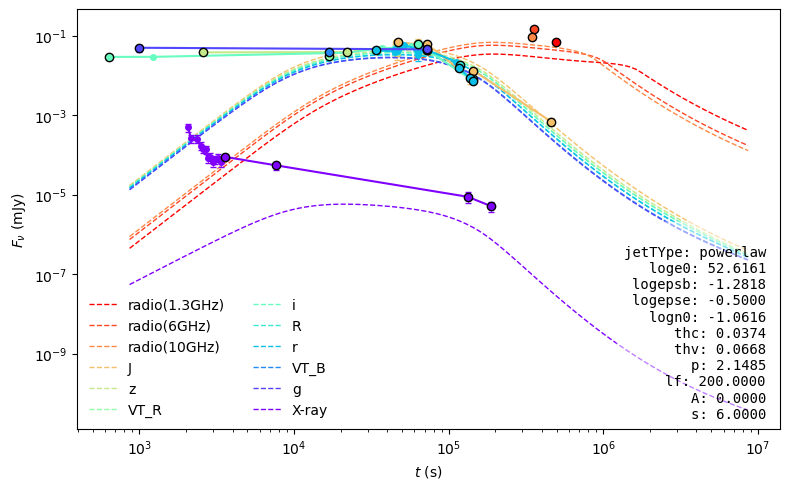

In [12]:
lc_plot(jetType='powerlaw',
    loge0=52.616085944159316, logepsb=-1.2817950618670402, s=6.0, 
    logn0=-1.0615603629426942, thc=0.03738114324346451, thv=0.06675981254963001, p=2.148516064908085,
    logepse=-0.5000044643265977,lf=200,
    z=0.661,
    observed_data='data/mcmc_df.csv',
    observed_data_fit='data/mcmc_df_trunc.csv',)